In [302]:
import random
import os
from dataset import dataset
import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import numpy as np
from scipy.stats import wilcoxon
import pandas as pd

In [303]:
def make_plots(f1_scores, loss_scores, names_list, figure_size, rotation_val):
    f1_data = [f1_scores[i] for i in range(len(f1_scores))]
    loss_data = [loss_scores[i] for i in range(len(loss_scores))]

    positions = np.arange(len(f1_scores))
    width = 0.4

    plt.figure(figsize=figure_size)
    plt.boxplot(f1_data, positions=positions, widths=width, patch_artist=True,
                boxprops=dict(facecolor='lightblue'), medianprops=dict(color='blue'),
                whiskerprops=dict(color='blue'), capprops=dict(color='blue'),
                flierprops=dict(markerfacecolor='blue', marker='o'))
    plt.xticks(positions, names_list, rotation=rotation_val)
    plt.xlabel('Datasets')
    plt.ylabel('F1 Score')
    plt.title('Average F1 Scores Across Datasets')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=figure_size)
    plt.boxplot(loss_data, positions=positions, widths=width, patch_artist=True,
                boxprops=dict(facecolor='lightcoral'), medianprops=dict(color='red'),
                whiskerprops=dict(color='red'), capprops=dict(color='red'),
                flierprops=dict(markerfacecolor='red', marker='o'))
    plt.xticks(positions, names_list, rotation=rotation_val)
    plt.xlabel('Datasets')
    plt.ylabel('0/1 Loss Score')
    plt.title('0/1 Loss Scores Across Datasets')
    plt.tight_layout()
    plt.show()

In [304]:
def create_comparison_tables(unaltered_loss, altered_loss, unaltered_f1, altered_f1, class_labels):
    """
    This function takes in the unaltered and altered loss lists, unaltered and altered F1 score matrices, 
    and the class labels, and returns two DataFrames:
    
    - Main table with 0/1 Loss and F1 scores statistics (Mean, Min, Max, Std).
    - P-value table comparing altered and unaltered results.
    
    Parameters:
    unaltered_loss: list of float or numpy array
    altered_loss: list of float or numpy array
    unaltered_f1: 2D list/ndarray of shape (n_models, n_classes)
    altered_f1: 2D list/ndarray of shape (n_models, n_classes)
    class_labels: list of strings

    Returns:
    combined_df: pandas DataFrame containing statistics for both unaltered and altered data.
    p_value_df: pandas DataFrame containing the p-values for 0/1 Loss and F1 scores.
    """

    # Convert to numpy arrays if the inputs are lists
    unaltered_loss = np.array(unaltered_loss) if isinstance(unaltered_loss, list) else unaltered_loss
    altered_loss = np.array(altered_loss) if isinstance(altered_loss, list) else altered_loss
    unaltered_f1 = np.array(unaltered_f1) if isinstance(unaltered_f1, list) else unaltered_f1
    altered_f1 = np.array(altered_f1) if isinstance(altered_f1, list) else altered_f1

    # Step 1: Calculate statistics for each group (mean, min, max, std)
    def calculate_stats(data):
        return {
            'mean': np.mean(data, axis=0),
            'min': np.min(data, axis=0),
            'max': np.max(data, axis=0),
            'std': np.std(data, axis=0)
        }

    unaltered_loss_stats = calculate_stats(unaltered_loss)
    altered_loss_stats = calculate_stats(altered_loss)
    unaltered_f1_stats = calculate_stats(unaltered_f1)
    altered_f1_stats = calculate_stats(altered_f1)

    # Step 2: Structure data into a pandas DataFrame, generalized for any number of classes
    def create_stats_df(loss_stats, f1_stats, group_name, class_labels):
        rows = []
        # Add the 0/1 loss row
        rows.append([group_name, '0/1 Loss', '—', loss_stats['mean'], loss_stats['min'], loss_stats['max'], loss_stats['std']])
        # Add rows for each class's F1 score
        for i, cls in enumerate(class_labels):
            rows.append([group_name, 'F1', cls, f1_stats['mean'][i], f1_stats['min'][i], f1_stats['max'][i], f1_stats['std'][i]])
        return pd.DataFrame(rows, columns=['Training Data', 'Measure', 'Positive Class', 'Mean', 'Min.', 'Max.', 'Std.'])

    # Create DataFrames for unaltered and altered data
    unaltered_df = create_stats_df(unaltered_loss_stats, unaltered_f1_stats, 'Unaltered', class_labels)
    altered_df = create_stats_df(altered_loss_stats, altered_f1_stats, 'Altered', class_labels)

    # Combine both tables
    combined_df = pd.concat([unaltered_df, altered_df], ignore_index=True)

    def calculate_p_values(unaltered, altered):
        """
        This function calculates the p-values using the Wilcoxon signed-rank test 
        for each feature across the unaltered and altered data. 
        It adds error handling to manage cases where the test fails.
        
        Parameters:
        unaltered: 2D array-like (n_models, n_features)
        altered: 2D array-like (n_models, n_features)
        
        Returns:
        p_values: list of p-values for each feature
        """
        # Ensure the inputs are 2D numpy arrays
        unaltered = np.array(unaltered)
        altered = np.array(altered)
        
        # Check if both unaltered and altered arrays have the same shape
        if unaltered.shape != altered.shape:
            raise ValueError("unaltered and altered arrays must have the same shape")

        p_values = []
        for i in range(unaltered.shape[1]):  # Iterate over features (columns)
            try:
                # Check if the data has variability (Wilcoxon requires this)
                if np.all(unaltered[:, i] == altered[:, i]):
                    p_values.append(1.0)  # No difference, hence p-value is 1
                else:
                    # Perform the Wilcoxon test for the i-th feature
                    stat, p_value = wilcoxon(unaltered[:, i], altered[:, i])
                    p_values.append(p_value)
            except ValueError as e:
                # Catch exceptions related to invalid input (e.g., constant values)
                print(f"Wilcoxon test failed for feature {i}: {e}")
                p_values.append(np.nan)  # Append NaN if the test fails

        return p_values

    # Calculate p-values for F1 scores and loss
    f1_p_values = calculate_p_values(unaltered_f1, altered_f1)
    loss_p_value = wilcoxon(unaltered_loss, altered_loss).pvalue

    # Create the p-value table
    p_value_rows = [
        ['0/1 Loss', '—', loss_p_value]
    ]
    for i, cls in enumerate(class_labels):
        p_value_rows.append(['F1', cls, f1_p_values[i]])

    p_value_df = pd.DataFrame(p_value_rows, columns=['Measure', 'Positive Class', 'p-value'])

    # Return both DataFrames
    return combined_df, p_value_df



In [305]:
def create_visual_tables(main_table, p_value_table):
    """
    This function takes in two pandas DataFrames (main_table and p_value_table) and generates
    a visual representation using matplotlib, displaying two tables: the main table and the p-value table.

    Parameters:
    main_table: pandas DataFrame containing statistics for both unaltered and altered data.
    p_value_table: pandas DataFrame containing the p-values for 0/1 Loss and F1 scores.
    """

    # Create a figure for the main table
    fig, ax = plt.subplots(figsize=(10, 4))  # Adjust size to your preference

    # Hide the axes
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Create the main table
    table_data = main_table.values.tolist()  # Convert the dataframe to a list of lists
    columns = main_table.columns.tolist()    # Get the column headers

    # Create the table in the figure
    table = ax.table(cellText=table_data, colLabels=columns, cellLoc='center', loc='center')

    # Set font size and styles for better visibility
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)  # Adjust scaling for better visibility

    # Apply styling for individual cells
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # This is the header
            cell.set_fontsize(12)
            cell.set_text_props(weight='bold')
            cell.set_facecolor("#40466e")  # Darker header background
            cell.set_text_props(color='white')  # White header text
        else:
            cell.set_edgecolor('grey')  # Lighter cell borders

    # Adding the p-value table below (as a separate figure)
    fig_p, ax_p = plt.subplots(figsize=(6, 2))  # Adjust size to your preference

    # Hide the axes
    ax_p.xaxis.set_visible(False)
    ax_p.yaxis.set_visible(False)
    ax_p.set_frame_on(False)

    # Convert the p-value table to a list of lists
    p_value_data = p_value_table.values.tolist()
    p_value_columns = p_value_table.columns.tolist()

    # Create the p-value table in the figure
    table_p = ax_p.table(cellText=p_value_data, colLabels=p_value_columns, cellLoc='center', loc='center')

    # Set font size and styles for p-value table
    table_p.auto_set_font_size(False)
    table_p.set_fontsize(10)
    table_p.scale(1.2, 1.2)

    # Styling for the p-value table
    for (i, j), cell in table_p.get_celld().items():
        if i == 0:  # Header styling
            cell.set_fontsize(12)
            cell.set_text_props(weight='bold')
            cell.set_facecolor("#40466e")
            cell.set_text_props(color='white')
        else:
            cell.set_edgecolor('grey')

    # Display both figures
    plt.show()

# Example usage:
# Assuming main_table and p_value_table are already created by the create_comparison_tables function

# Example DataFrames (replace with actual ones)
# create_visual_tables(main_table, p_value_table)


In [306]:
class algorithm:
    def __init__(self, data_array:dataset, which_data:str):
        # The algorithm takes in a pre-processed dataset object, there shouldn't be much to do with the constructor except maybe a setter for the dataset
        self.data_array = data_array.partitions
        self.feature_probs = {}
        self.class_priors = {}
        self.predictions = []
        self.answers = []
        self.all_f1_scores_per_class = []

        # Determines label type
        cancer_labels = ['2','4']
        glass_labels = ['1','2','3','4','5','6','7']
        iris_labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
        soybean_labels = ['D1','D2','D3','D4']
        votes_labels = ['republican','democrat']
        if (which_data == 'cancer'):
            self.labels = cancer_labels
        elif (which_data == 'glass'):
            self.labels = glass_labels
        elif (which_data == 'iris'):
            self.labels = iris_labels
        elif (which_data == 'soybean'):
            self.labels = soybean_labels
        elif (which_data == 'votes'):
            self.labels = votes_labels
        
        # Stores the class labels in an array where the first indice is the partition and the second indice stores class labels for each example
        self.labels_2d = []
        for fold_i in range(len(self.data_array)):
            self.labels_2d.append([])
            for example_i in range(len(self.data_array[fold_i])):
                self.labels_2d[fold_i].append(self.data_array[fold_i][example_i][-1])

    def train(self):
        num_folds = len(self.data_array)

        # Loop through each fold
        for fold_idx in range(num_folds):
            # call the get_train_test method to store training data, training labels, test data, and test labels
            train_data, train_labels, test_data, test_labels = self._get_train_test(fold_idx)
        
            # Store each class label in the training data within a set
            unique_classes = set(train_labels)
            
            # Instantiate default dictionaries to store class frequency, feature frequency, and the total number of features
            class_counts = defaultdict(int)
            feature_counts = defaultdict(lambda: defaultdict(int))   #creates a nested dictionary to store feature frequencies by class
            feature_totals = defaultdict(int)
            
            num_examples = len(train_labels)  #store the total number of examples
            #print(f"Nume_Examples: {num_examples}") #print the number of examples
            
            # Print training data and labels to verify they are correctly loaded
            #train_data, train_labels, test_data, test_labels = self._get_train_test(fold_idx)
            #print(f"Training data for fold {fold_idx}: {train_data}")
            #print(f"Training labels for fold {fold_idx}: {train_labels}")

            # Print training labels for verification
            #print(f"Train labels for fold {fold_idx}: {train_labels}")          

            for example, label in zip(train_data, train_labels):
                class_counts[label] += 1  # Increment the count for the class
                for feature_idx, feature_value in enumerate(example):
                    feature_counts[label][feature_idx, feature_value] += 1  # Increment the number of instances of a feature within a given class
                    feature_totals[label] += 1 #Increment the count for the feature

            # Print out class counts for verification
            #print(f"Class counts for fold {fold_idx}: {class_counts}")

            # Calculate the class priors
            self.class_priors[fold_idx] = {}
            # Iterate through each class
            for cls in unique_classes:
                # Calculate the prior probability of each class
                self.class_priors[fold_idx][cls] = (class_counts[cls]) / (num_examples)

            # Print out prior probabilities for verification
            #print(f"Class priors for fold {fold_idx}: {self.class_priors[fold_idx]}")

            # Calculate feature probabilities
            self.feature_probs[fold_idx] = defaultdict(lambda: defaultdict(float))  #create a nested dictionary to storefeaturee probbilities for each fold 
            for label in unique_classes: #iterate throughg each class
                for feature, count in feature_counts[label].items():  #iterate through the feature counts for each clas
                    self.feature_probs[fold_idx][label][feature] = (count + 1) / (feature_totals[label] + len(feature_counts[label])) #calculate the feature probabilities and store them in the nested dictionary
                    #Self.feature_probs stores the probabilities where the outer dictionary is the fold, the middle dictionary is the class, and the inner dictionary is the feature probabilities


            # Use the calculated prior probabilities and feature probabilities to classify the test data.
            fold_predictions = [] 
            for example in test_data:  #iteraate through each example in the test data
                predicted_label = self.predict(example, fold_idx) #call the predict method to classify an example for a specified fold
                fold_predictions.append(predicted_label) #store the predicted class label for the fold
            self.predictions.append(fold_predictions) # store the predicted class for each fold

    def predict(self, example, fold_idx):
        """
        Predict the label of a single example using the trained model for a specific fold.
        """
        class_probs = {}
        train_data, train_labels, test_data, test_labels = self._get_train_test(fold_idx)  # call _get_train_test method to reinstantiate train_labels
        unique_classes = set(train_labels) #create a set of the class labels in the training data

        # Compute the probbility of an example belonging to each class
        for label in unique_classes:
            #iterate through each fold
            if label in self.class_priors[fold_idx]:
                prob = self.class_priors[fold_idx][label] #get the probability of a class in the fold
            else:
                # If the class didn't show up in training, apply a very small probability for it
                prob = 1 / (len(self.class_priors[fold_idx]) + 1)

            # iterate through each feature in an example
            for feature_idx, feature_value in enumerate(example):
                # If a feature has an associated probability for the class, mutiply the probablity by the prior probability
                if (feature_idx, feature_value) in self.feature_probs[fold_idx][label]:
                    prob *= self.feature_probs[fold_idx][label][(feature_idx, feature_value)]
                else:
                    # If the feature didn't show up in training, apply a very small probabilty for it
                    prob *= 1 / (len(self.feature_probs[fold_idx][label]) + 1)
            
            class_probs[label] = prob
            #store the probability that the example belongs to each class

        # Return the most probable class
        if class_probs:
            return max(class_probs, key=class_probs.get)
        else:
            #If class_probs calculation fails, return None
            return None  # or a default class, if you prefer

    def _get_train_test(self, fold_idx):
            """
            Helper method to split data into training and testing sets based on fold_idx.
            """
            test_data = self.data_array[fold_idx] #pull outthe test fold and store it
            test_labels = self.labels_2d[fold_idx] #pull out the test labels and store them

            # Combine all other folds for training
            train_data = []
            train_labels = []
            for i in range(len(self.data_array)): #iterate through each fold
                if i != fold_idx:         #ignore ethe test fold
                    train_data.extend(self.data_array[i]) #store training data as an array
                    train_labels.extend(self.labels_2d[i]) #store training labels in an array

            return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)  #Convert to numpy arrays and return all four arrays

    def calculate_loss(self):
            """ 
            This method will analyze the classification, and determine, TP, TN, FP, FN, F1 loss, 0/1 loss, etc.
            These results need to be saved
            We will also want to create a box plot where the x-axis is the dataset we worked with (10 datasets), and y axis is a performance metric (whatever we want). For each dataset there will be 10 datapoints in the box, each point represents the performance of one of the folds.
            """
            
            self.zero_one_losses = []  
            self.f1_scores = []
            for fold_index in range(10): #iterate through all the folds
                test_fold = self.data_array[fold_index] #pull out the test fold
                #Create dictionaries to store TP, FP, and FN
                true_positives = {label: 0 for label in self.labels}      
                false_positives = {label: 0 for label in self.labels}
                false_negatives = {label: 0 for label in self.labels}
                
                correct_predictions = 0
                total_predictions = len(test_fold)  # Save the number of examples in the test set

                #Iterate through each prediction
                for i in range(total_predictions):
                    true_label = self.data_array[fold_index][i][-1] #store the correct label for the example
                    predicted_label = self.predictions[fold_index][i] #Store the predicted label for the example

                    #Calculate TP, FP, and FN
                    if predicted_label == true_label:
                        #If the predicted label matches the true label, increment correct predictions and true positives
                        correct_predictions += 1
                        true_positives[true_label] += 1
                    else:
                        #If the predicted label doesn't match the true label, increment false negatives and false positives
                        if predicted_label in self.labels: #check if the predicted label is valid before incrementing false positives
                            false_positives[predicted_label] += 1 
                        false_negatives[true_label] += 1
                    
                #Calculate 0/1 loss
                loss = 1 - (correct_predictions / total_predictions)
                self.zero_one_losses.append(loss)


                #Calculate F1 scores
                f1_scores_per_class = []
                for label in self.labels:  # Iterate through each class
                    # For each class calculate precision, p = TP / (TP +FP)
                    precision = (true_positives[label] / (true_positives[label] + false_positives[label])
                            if (true_positives[label] + false_positives[label]) > 0 else 0)
                    # For each class calculate recall, r = TP / (TP +FN)
                    recall = (true_positives[label] / (true_positives[label] + false_negatives[label])
                            if (true_positives[label] + false_negatives[label]) > 0 else 0)
                    # for each class calculate F1 score, f1 = 2 x (p x r)/(p + r)
                    f1 = ((2 * (precision * recall)) / (precision + recall)) if (precision + recall) > 0 else 0
                    f1_scores_per_class.append(f1)
                self.all_f1_scores_per_class.append(f1_scores_per_class)
                #Average the class f1 scores to get a full model f1 score
                average_f1 = sum(f1_scores_per_class) / len(self.labels)
                self.f1_scores.append(average_f1)

In [307]:
cancer_nopre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/cancer_nopre.csv', 'last', True)
glass_nopre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/glass_nopre.csv', 'last', True)
glass_nopre.discretize(10, True)
votes_nopre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/votes_nopre.csv', 'first', True)
iris_nopre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/iris_nopre.csv', 'last', True)
iris_nopre.discretize(10, False)
soybean_nopre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/soybean_nopre.csv', 'last', True)

cancer_pre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/cancer_pre.csv', 'last', True)
glass_pre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/glass_pre.csv', 'last', True)
votes_pre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/votes_pre.csv', 'first', True)
iris_pre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/iris_pre.csv', 'last', True)
soybean_pre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/soybean_pre.csv', 'last', True)

In [308]:
cancer_nopre_processing = algorithm(cancer_nopre, 'cancer')
glass_nopre_processing = algorithm(glass_nopre, 'glass')
votes_nopre_processing = algorithm(votes_nopre, 'votes')
iris_nopre_processing = algorithm(iris_nopre, 'iris')
soybean_nopre_processing = algorithm(soybean_nopre, 'soybean')

cancer_pre_processing = algorithm(cancer_pre, 'cancer')
glass_pre_processing = algorithm(glass_pre, 'glass')
votes_pre_processing = algorithm(votes_pre, 'votes')
iris_pre_processing = algorithm(iris_pre, 'iris')
soybean_pre_processing = algorithm(soybean_pre, 'soybean')

In [309]:
cancer_nopre_processing.train()
glass_nopre_processing.train()
votes_nopre_processing.train()
iris_nopre_processing.train()
soybean_nopre_processing.train()

cancer_pre_processing.train()
glass_pre_processing.train()
votes_pre_processing.train()
iris_pre_processing.train()
soybean_pre_processing.train()
print(f"Prior Probs:   {glass_nopre_processing.class_priors}")
print(f"Prior Probs:   {iris_nopre_processing.class_priors}")
print(f"Feature Probs: {iris_nopre_processing.feature_probs}")

Prior Probs:   {0: {'7': 0.140625, '1': 0.3229166666666667, '6': 0.041666666666666664, '3': 0.07291666666666667, '2': 0.359375, '5': 0.0625}, 1: {'7': 0.140625, '1': 0.3177083333333333, '5': 0.06770833333333333, '3': 0.07291666666666667, '2': 0.3541666666666667, '6': 0.046875}, 2: {'7': 0.13020833333333334, '1': 0.3125, '5': 0.0625, '3': 0.08854166666666667, '2': 0.3645833333333333, '6': 0.041666666666666664}, 3: {'7': 0.14583333333333334, '1': 0.3489583333333333, '5': 0.052083333333333336, '3': 0.07291666666666667, '2': 0.3385416666666667, '6': 0.041666666666666664}, 4: {'7': 0.14507772020725387, '1': 0.30569948186528495, '5': 0.06735751295336788, '3': 0.08290155440414508, '2': 0.35233160621761656, '6': 0.046632124352331605}, 5: {'7': 0.12953367875647667, '1': 0.32642487046632124, '5': 0.05699481865284974, '3': 0.07772020725388601, '2': 0.36787564766839376, '6': 0.04145077720207254}, 6: {'7': 0.13471502590673576, '1': 0.32642487046632124, '5': 0.06735751295336788, '3': 0.0777202072538

In [310]:
cancer_nopre_processing.calculate_loss()
glass_nopre_processing.calculate_loss()
votes_nopre_processing.calculate_loss()
iris_nopre_processing.calculate_loss()
soybean_nopre_processing.calculate_loss()

cancer_pre_processing.calculate_loss()
glass_pre_processing.calculate_loss()
votes_pre_processing.calculate_loss()
iris_pre_processing.calculate_loss()
soybean_pre_processing.calculate_loss()


answers = []
for i in range(10):
    answers.append([])
    for j in range(len(soybean_nopre_processing.data_array[i])):
        answers[i].append(soybean_nopre_processing.data_array[i][j][-1])
print(f"Class Probs: {soybean_nopre_processing.class_priors}")
print(f"Feature Pro: {soybean_nopre_processing.feature_probs}")
print(f"Predictions: {soybean_nopre_processing.predictions}")
print(f"Answers:     {answers}")

Class Probs: {0: {'D1': 0.23809523809523808, 'D3': 0.19047619047619047, 'D4': 0.35714285714285715, 'D2': 0.21428571428571427}, 1: {'D4': 0.3333333333333333, 'D3': 0.23809523809523808, 'D1': 0.23809523809523808, 'D2': 0.19047619047619047}, 2: {'D4': 0.35714285714285715, 'D3': 0.19047619047619047, 'D1': 0.21428571428571427, 'D2': 0.23809523809523808}, 3: {'D4': 0.35714285714285715, 'D3': 0.21428571428571427, 'D1': 0.19047619047619047, 'D2': 0.23809523809523808}, 4: {'D4': 0.35714285714285715, 'D3': 0.21428571428571427, 'D1': 0.23809523809523808, 'D2': 0.19047619047619047}, 5: {'D4': 0.38095238095238093, 'D3': 0.21428571428571427, 'D1': 0.19047619047619047, 'D2': 0.21428571428571427}, 6: {'D4': 0.40476190476190477, 'D3': 0.16666666666666666, 'D1': 0.19047619047619047, 'D2': 0.23809523809523808}, 7: {'D4': 0.3488372093023256, 'D3': 0.23255813953488372, 'D1': 0.18604651162790697, 'D2': 0.23255813953488372}, 8: {'D4': 0.3488372093023256, 'D3': 0.23255813953488372, 'D1': 0.23255813953488372, 

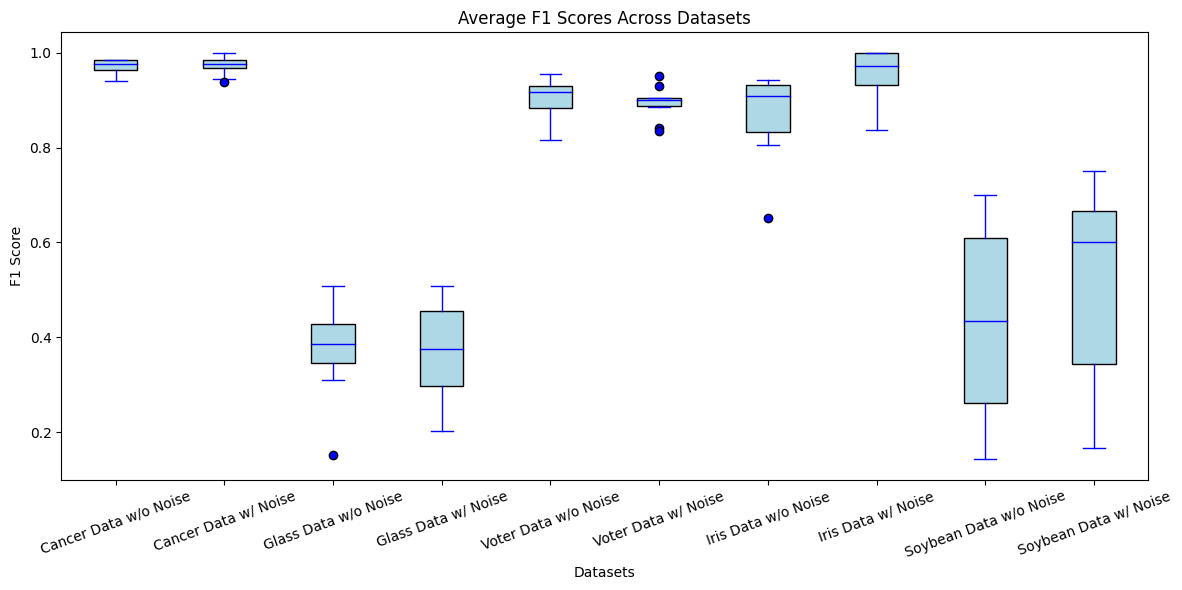

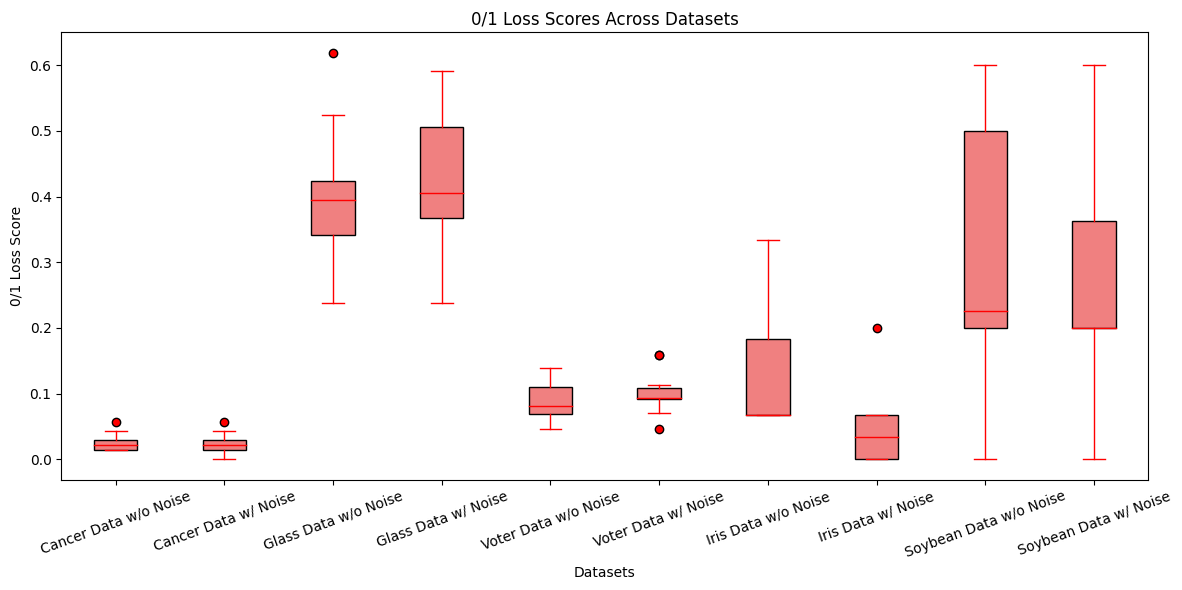

In [311]:
zero_one_list = [cancer_nopre_processing.zero_one_losses, cancer_pre_processing.zero_one_losses, glass_nopre_processing.zero_one_losses, glass_pre_processing.zero_one_losses, votes_nopre_processing.zero_one_losses, votes_pre_processing.zero_one_losses, iris_nopre_processing.zero_one_losses, iris_pre_processing.zero_one_losses, soybean_nopre_processing.zero_one_losses, soybean_pre_processing.zero_one_losses]
f1_scores_list = [cancer_nopre_processing.f1_scores, cancer_pre_processing.f1_scores, glass_nopre_processing.f1_scores, glass_pre_processing.f1_scores, votes_nopre_processing.f1_scores, votes_pre_processing.f1_scores, iris_nopre_processing.f1_scores, iris_pre_processing.f1_scores, soybean_nopre_processing.f1_scores, soybean_pre_processing.f1_scores]
names_list = ['Cancer Data w/o Noise','Cancer Data w/ Noise','Glass Data w/o Noise','Glass Data w/ Noise','Voter Data w/o Noise','Voter Data w/ Noise','Iris Data w/o Noise','Iris Data w/ Noise','Soybean Data w/o Noise','Soybean Data w/ Noise']
figure_size = (12,6)
make_plots(f1_scores_list, zero_one_list, names_list, figure_size, 20)

In [312]:
cancer_main_table, cancer_p_value_table = create_comparison_tables(cancer_nopre_processing.zero_one_losses, cancer_pre_processing.zero_one_losses, cancer_nopre_processing.all_f1_scores_per_class, cancer_pre_processing.all_f1_scores_per_class, cancer_nopre_processing.labels)
print("Cancer Main Table:")
print(cancer_main_table)
print("\n Cancer P-value Table:")
print(cancer_p_value_table)

Cancer Main Table:
  Training Data   Measure Positive Class      Mean      Min.      Max.  \
0     Unaltered  0/1 Loss              —  0.025776  0.014286  0.057143   
1     Unaltered        F1              2  0.979875  0.952381  0.990099   
2     Unaltered        F1              4  0.962448  0.928571  0.982456   
3       Altered  0/1 Loss              —  0.024306  0.000000  0.057143   
4       Altered        F1              2  0.981322  0.954545  1.000000   
5       Altered        F1              4  0.964172  0.918919  1.000000   

       Std.  
0  0.014074  
1  0.011548  
2  0.020295  
3  0.015701  
4  0.012080  
5  0.024578  

 Cancer P-value Table:
    Measure Positive Class   p-value
0  0/1 Loss              —  0.777838
1        F1              2  1.000000
2        F1              4  0.845703


/home/carlos/.conda/envs/lesion_count/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/carlos/.conda/envs/lesion_count/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [313]:
print(glass_nopre_processing.all_f1_scores_per_class)
glass_main_table, glass_p_value_table = create_comparison_tables(glass_nopre_processing.zero_one_losses, glass_pre_processing.zero_one_losses, glass_nopre_processing.all_f1_scores_per_class, glass_pre_processing.all_f1_scores_per_class, glass_nopre_processing.labels)
print("\nglass Main Table:")
print(glass_main_table)
print("\n glass P-value Table:")
print(glass_p_value_table)

[[0.6666666666666666, 0.923076923076923, 0.4615384615384615, 0, 0, 0.6666666666666666, 0], [0.8888888888888888, 0.5454545454545454, 0.4444444444444444, 0, 0, 0, 1.0], [0.8235294117647058, 0.6666666666666666, 0, 0, 0, 0.4, 0.6666666666666666], [0.8571428571428571, 0.7058823529411764, 0.4615384615384615, 0, 0, 0, 1.0], [0.6666666666666665, 0.4, 0, 0, 0, 0, 0], [0.6153846153846153, 0.5714285714285715, 0, 0, 0, 0.33333333333333337, 0.8571428571428571], [0.8333333333333333, 0.923076923076923, 0.5, 0, 0, 0.8, 0.5], [0.7272727272727273, 0.7777777777777778, 0, 0, 0, 0, 0.6666666666666666], [0.8000000000000002, 0.888888888888889, 0.2222222222222222, 0, 0, 1.0, 0.6], [0.923076923076923, 0.8571428571428571, 0, 0, 0, 0.4, 0.5]]

glass Main Table:
   Training Data   Measure Positive Class      Mean      Min.      Max.  \
0      Unaltered  0/1 Loss              —  0.402381  0.238095  0.619048   
1      Unaltered        F1              1  0.780196  0.615385  0.923077   
2      Unaltered        F1    

/home/carlos/.conda/envs/lesion_count/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/carlos/.conda/envs/lesion_count/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [314]:
votes_main_table, votes_p_value_table = create_comparison_tables(votes_nopre_processing.zero_one_losses, votes_pre_processing.zero_one_losses, votes_nopre_processing.all_f1_scores_per_class, votes_pre_processing.all_f1_scores_per_class, votes_nopre_processing.labels)
print("\nvotes Main Table:")
print(votes_main_table)
print("\n votes P-value Table:")
print(votes_p_value_table)


votes Main Table:
  Training Data   Measure Positive Class      Mean      Min.      Max.  \
0     Unaltered  0/1 Loss              —  0.087368  0.045455  0.139535   
1     Unaltered        F1     republican  0.879688  0.727273  0.956522   
2     Unaltered        F1       democrat  0.927781  0.900000  0.956522   
3       Altered  0/1 Loss              —  0.100899  0.046512  0.159091   
4       Altered        F1     republican  0.874288  0.800000  0.941176   
5       Altered        F1       democrat  0.913328  0.844444  0.961538   

       Std.  
0  0.032244  
1  0.070410  
2  0.020002  
3  0.033538  
4  0.038654  
5  0.034129  

 votes P-value Table:
    Measure Positive Class   p-value
0  0/1 Loss              —  0.513930
1        F1     republican  0.375000
2        F1       democrat  0.695312


/home/carlos/.conda/envs/lesion_count/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/carlos/.conda/envs/lesion_count/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [315]:
print(iris_pre_processing.all_f1_scores_per_class)
iris_main_table, iris_p_value_table = create_comparison_tables(iris_nopre_processing.zero_one_losses, iris_pre_processing.zero_one_losses, iris_nopre_processing.all_f1_scores_per_class, iris_pre_processing.all_f1_scores_per_class, iris_nopre_processing.labels)
print("\niris Main Table:")
print(iris_main_table)
print("\n iris P-value Table:")
print(iris_p_value_table)

[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [0.923076923076923, 0.9090909090909091, 1.0], [1.0, 1.0, 1.0], [1.0, 0.6666666666666665, 0.8421052631578948], [1.0, 0.8571428571428571, 0.9333333333333333], [1.0, 0.923076923076923, 0.888888888888889], [0.8571428571428571, 1.0, 0.9090909090909091], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]

iris Main Table:
  Training Data   Measure   Positive Class      Mean      Min.      Max.  \
0     Unaltered  0/1 Loss                —  0.133333  0.066667  0.333333   
1     Unaltered        F1      Iris-setosa  0.950062  0.727273  1.000000   
2     Unaltered        F1  Iris-versicolor  0.881080  0.666667  1.000000   
3     Unaltered        F1   Iris-virginica  0.770653  0.285714  1.000000   
4       Altered  0/1 Loss                —  0.046667  0.000000  0.200000   
5       Altered        F1      Iris-setosa  0.978022  0.857143  1.000000   
6       Altered        F1  Iris-versicolor  0.935598  0.666667  1.000000   
7       Altered        F1   Iris-virginica  0.957342  0.

/home/carlos/.conda/envs/lesion_count/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/carlos/.conda/envs/lesion_count/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [316]:
soybean_main_table, soybean_p_value_table = create_comparison_tables(soybean_nopre_processing.zero_one_losses, soybean_pre_processing.zero_one_losses, soybean_nopre_processing.all_f1_scores_per_class, soybean_pre_processing.all_f1_scores_per_class, soybean_nopre_processing.labels)
print("\nsoybean Main Table:")
print(cancer_main_table)
print("\n soybean P-value Table:")
print(cancer_p_value_table)


soybean Main Table:
  Training Data   Measure Positive Class      Mean      Min.      Max.  \
0     Unaltered  0/1 Loss              —  0.025776  0.014286  0.057143   
1     Unaltered        F1              2  0.979875  0.952381  0.990099   
2     Unaltered        F1              4  0.962448  0.928571  0.982456   
3       Altered  0/1 Loss              —  0.024306  0.000000  0.057143   
4       Altered        F1              2  0.981322  0.954545  1.000000   
5       Altered        F1              4  0.964172  0.918919  1.000000   

       Std.  
0  0.014074  
1  0.011548  
2  0.020295  
3  0.015701  
4  0.012080  
5  0.024578  

 soybean P-value Table:
    Measure Positive Class   p-value
0  0/1 Loss              —  0.777838
1        F1              2  1.000000
2        F1              4  0.845703


/home/carlos/.conda/envs/lesion_count/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/carlos/.conda/envs/lesion_count/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
